In [139]:
import sys

sys.path.append("../")

In [140]:
import pandas as pd
import numpy as np
from statsmodels.tsa.stattools import adfuller, kpss
from datetime import datetime, timedelta
from arch.unitroot import PhillipsPerron
import statsmodels.api as sm
import statsmodels.formula.api as smf

import matplotlib.pyplot as plt

DATA_PATH = '/mnt/d/Trading/trading-agent/crypto-pair-trading/data/5min'

In [141]:
selected_pairs = ['DOT-USDT', 'LINK-USDT', 'BCH-USDT']

data = []
start_date = '2021-06-01'

for symbol in selected_pairs:
    try:
        df = pd.read_csv(f'{DATA_PATH}/{symbol}.csv', 
                        parse_dates=['open_time'], 
                        index_col=['open_time'])

        df.rename(columns={'close': symbol}, inplace=True)
        # the data is too long, just limit to recent period
        data.append(df[df.index > start_date][symbol])
    except:
        pass

df = pd.concat(data, axis=1)
df = df.dropna(axis=1, how='all')
df.dropna(inplace=True, how='any')

df.tail()

,DOT-USDT,LINK-USDT,BCH-USDT
open_time,,,
2021-08-30 00:40:00,25.55,25.51,655.5
2021-08-30 00:45:00,25.30,25.39,654.7
2021-08-30 00:50:00,25.28,25.31,653.8
2021-08-30 00:55:00,25.33,25.37,654.2
2021-08-30 01:00:00,25.36,25.42,654.6


In [142]:
def adf_test(timeseries, verbose=False):
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    
    if verbose:
        print ('Results of Dickey-Fuller Test:')
        for key,value in dftest[4].items():
            dfoutput['Critical Value (%s)'%key] = value
        print(dfoutput)
    return dfoutput['p-value']

In [143]:
def pp_test(timeseries, verbose=False):
    pp = PhillipsPerron(timeseries)
    if verbose:
        print(pp.summary().as_text())
    
    return pp.pvalue


def kpss_test(timeseries, verbose=False):
    kpsstest = kpss(timeseries, regression='c', nlags="auto")
    kpss_output = pd.Series(kpsstest[0:3], index=['Test Statistic','p-value','Lags Used'])

    if verbose:
        print ('Results of KPSS Test:')
        for key,value in kpsstest[3].items():
            kpss_output['Critical Value (%s)'%key] = value
        print (kpss_output)
    return kpss_output['p-value']


In [144]:
methods = {
    'adf': adf_test,
    'pp': pp_test,
    'kpss': kpss_test
}


def perform_test(method, series):
    func_ = methods[method]
    
    # p_v1 = func_(np.log(series))
    p_v1 = func_(series)

    # diff = np.log(series) - np.log(series.shift(1))
    diff = series.diff()
    diff.dropna(inplace=True)
    p_v2 = func_(diff)

    return p_v1, p_v2

In [145]:
data = {
    'adf': [],
    'pp': [],
    'kpss': []
}
columns = []

for col in df.columns:
    for test in methods.keys():
        p1, p2 = perform_test(test, df[col])
        data[test].append(p1)
        data[test].append(p2)
    
    if col not in columns:
        columns.append(col)
    
    if f'd_{col}' not in columns:
        columns.append(f'd_{col}')

    

test_df = pd.DataFrame.from_dict(data, orient='index', columns=columns)
test_df.head()

/home/bean/miniconda3/envs/trade/lib/python3.7/site-packages/statsmodels/tsa/stattools.py:1907: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  warn_msg.format(direction="smaller"), InterpolationWarning
/home/bean/miniconda3/envs/trade/lib/python3.7/site-packages/statsmodels/tsa/stattools.py:1911: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning
/home/bean/miniconda3/envs/trade/lib/python3.7/site-packages/statsmodels/tsa/stattools.py:1907: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  warn_msg.format(direction="smaller"), InterpolationWarning
/home/bean/miniconda3/envs/t

,DOT-USDT,d_DOT-USDT,LINK-USDT,d_LINK-USDT,BCH-USDT,d_BCH-USDT
adf,0.722722,0.0,0.191772,0.000000,0.383526,0.000000
pp,0.704690,0.0,0.167565,0.000000,0.363710,0.000000
kpss,0.010000,0.1,0.010000,0.072821,0.010000,0.092692


The prices are not stationary but they all become stationary after the first differencing.
For both adf and pp for the first differencing, `p-value` < 0.05 so we can reject the null.
KPSS all 3 diff series is above the critical value so we can accept the null (series is stationary).

Therefore, we can conclude that ETH, BCH, XLM are `I(1)` processes.

which:
- I(0): trend stationary
- I(1): diference stationary


The Engle-Granger method involves a linear regression on given time series data which,
in this case, is BTC; but it is not important which cryptocurrency is taken as the dependent
variable. We propose the following OLS model:

$$
ETH_t = c + \beta_1 BCH_t + \beta_2 XLM_t + \epsilon_t
$$

In [146]:
renamed = {col: col.replace('-USDT', '') for col in df.columns}

df.rename(columns=renamed, inplace=True)

In [147]:
df = sm.add_constant(df)
df

/home/bean/miniconda3/envs/trade/lib/python3.7/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


,const,DOT,LINK,BCH
open_time,,,,
2021-06-01 00:05:00,1.0,23.414,32.418,707.06
2021-06-01 00:10:00,1.0,23.406,32.302,705.69
2021-06-01 00:15:00,1.0,23.238,31.946,702.74
2021-06-01 00:20:00,1.0,23.249,32.045,703.85
2021-06-01 00:25:00,1.0,23.311,32.043,707.08
...,...,...,...,...
2021-08-30 00:40:00,1.0,25.550,25.510,655.50
2021-08-30 00:45:00,1.0,25.300,25.390,654.70
2021-08-30 00:50:00,1.0,25.280,25.310,653.80


In [171]:

model = sm.OLS.from_formula(formula='DOT ~ const + LINK + BCH', data=df)

results = model.fit()

print(results.summary())

                            OLS Regression Results                            
Dep. Variable:                    DOT   R-squared:                       0.915
Model:                            OLS   Adj. R-squared:                  0.915
Method:                 Least Squares   F-statistic:                 1.372e+05
Date:                Sat, 11 Sep 2021   Prob (F-statistic):               0.00
Time:                        15:18:35   Log-Likelihood:                -44768.
No. Observations:               25498   AIC:                         8.954e+04
Df Residuals:                   25495   BIC:                         8.957e+04
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -5.5182      0.043   -127.413      0.0

From above Table, we obtain the relationships:

$$
ETH = 0.38 + 1.141BCH + 0.08XLM + \epsilon_t
$$

Notably, all the regressing coefficients appear to be statistically significant with p-values less than 1%.
R-squared: 0.935%.

In [172]:
results.resid.head()

open_time
2021-06-01 00:05:00   -4.205145
2021-06-01 00:10:00   -4.135099
2021-06-01 00:15:00   -4.128758
2021-06-01 00:20:00   -4.181289
2021-06-01 00:25:00   -4.286995
dtype: float64

In [173]:
results.params

Intercept   -5.518237
const       -5.518237
LINK         0.059173
BCH          0.051958
dtype: float64

<AxesSubplot:xlabel='open_time'>

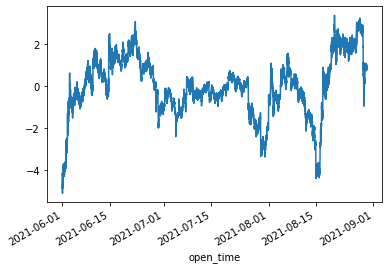

In [174]:
results.resid.plot()

In [175]:
adf_test(results.resid, verbose=True)

Results of Dickey-Fuller Test:
Test Statistic                    -3.829768
p-value                            0.002617
#Lags Used                         5.000000
Number of Observations Used    25492.000000
Critical Value (1%)               -3.430607
Critical Value (5%)               -2.861653
Critical Value (10%)              -2.566830
dtype: float64


0.0026170154884290293

In [176]:
pp_test(results.resid, verbose=True)

     Phillips-Perron Test (Z-tau)    
Test Statistic                 -3.791
P-value                         0.003
Lags                               48
-------------------------------------

Trend: Constant
Critical Values: -3.43 (1%), -2.86 (5%), -2.57 (10%)
Null Hypothesis: The process contains a unit root.
Alternative Hypothesis: The process is weakly stationary.


0.0030001243009564445

In [177]:
kpss_test(results.resid, verbose=True)

Results of KPSS Test:
Test Statistic            1.475071
p-value                   0.010000
Lags Used                94.000000
Critical Value (10%)      0.347000
Critical Value (5%)       0.463000
Critical Value (2.5%)     0.574000
Critical Value (1%)       0.739000
dtype: float64


/home/bean/miniconda3/envs/trade/lib/python3.7/site-packages/statsmodels/tsa/stattools.py:1907: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  warn_msg.format(direction="smaller"), InterpolationWarning


0.01

In [178]:
s1 = df['DOT']
s2 = df['LINK']
s3 = df['BCH']

hedge_ratio = (results.params['LINK'], results.params['BCH'])

spread = s1 - hedge_ratio[0] * s2 - hedge_ratio[1] * s3 # - hedge_ratio[2] * s4
spread 

open_time
2021-06-01 00:05:00   -15.241620
2021-06-01 00:10:00   -15.171574
2021-06-01 00:15:00   -15.165232
2021-06-01 00:20:00   -15.217764
2021-06-01 00:25:00   -15.323469
                         ...    
2021-08-30 00:40:00   -10.017906
2021-08-30 00:45:00   -10.219239
2021-08-30 00:50:00   -10.187743
2021-08-30 00:55:00   -10.162076
2021-08-30 01:00:00   -10.155818
Length: 25498, dtype: float64

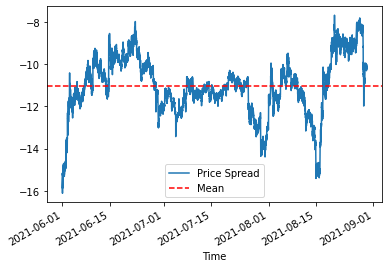

In [179]:
spread.plot() # Plot the spread
plt.axhline(spread.mean(), color='red', linestyle='--') # Add the mean
plt.xlabel('Time')
plt.legend(['Price Spread', 'Mean'])

In [180]:
def zscore(series):
    return (series - series.mean()) / np.std(series)

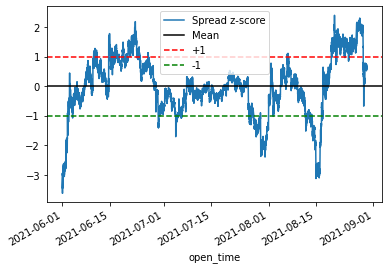

In [181]:
zscore(spread).plot()
plt.axhline(zscore(spread).mean(), color='black')
plt.axhline(1.0, color='red', linestyle='--')
plt.axhline(-1.0, color='green', linestyle='--')
plt.legend(['Spread z-score', 'Mean', '+1', '-1'])